In [1]:
### automatically refresh the buffer

%load_ext autoreload
%autoreload 2

### solve the auto-complete issue

%config Completer.use_jedi = False

### lvl 1 setups

import sys
sys.path.append('/portal1/dell/GitHub/WAYS')
sys.path.append('/portal1/dell/GitHub/sanctuary')

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)

### lvl 2 setups (systerm)

import os
import numpy as np
import pandas as pd
import xarray as xr
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from statsmodels.distributions.empirical_distribution import ECDF
from numpy import hstack
from matplotlib import pyplot
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from statsmodels.regression.quantile_regression import QuantReg
from math import isnan

In [2]:
from numpy import polyfit, poly1d

In [6]:
import os
import glob
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib as mpl
from matplotlib import cm
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from stats import cr
from gistool import basemap, stack_image, stack_shp, stack_hatch, stack_shp_cn, ncslice
from spatial import upscale
import statsmodels.formula.api as smf
from scipy.stats.mstats import theilslopes
from scipy.stats import kendalltau
import cartopy.crs as ccrs

In [7]:
shp='/portal3/gis/LMRB_Boundary/Lancang_Mekong_Basin/Lancang_Mekong_Basin.shp'
shp2='/portal3/gis/Global_countries/world_map_latest/World_Countries__Generalized_.shp'
shp4='/portal3/gis/Mekong_Delta/mekong_river.shp'

In [8]:
ds_wetseason_prec = xr.open_dataset('monthly_data/LMRB_wetseason_prec.nc')
ds_dryseason_prec = xr.open_dataset('monthly_data/LMRB_dryseason_prec.nc')

In [9]:
tp_wet = ds_wetseason_prec.tp.values
tp_dry = ds_dryseason_prec.tp.values

# Quantile regression of wet and dry season precipitation

In [14]:
data = pd.DataFrame(data = ds_wetseason_prec.time.values,columns = ['x'])
data['y']= np.nanmean(tp_wet,axis=(1,2))
mod = smf.quantreg('y~x',data)

In [15]:
data

,x,y
0,1960-05-31,170.493469
1,1960-06-30,248.569748
2,1960-07-31,282.366547
3,1960-08-31,290.285004
4,1960-09-30,267.228760
...,...,...
373,2022-06-30,189.639435
374,2022-07-31,258.737518
375,2022-08-31,293.021576
376,2022-09-30,312.809509


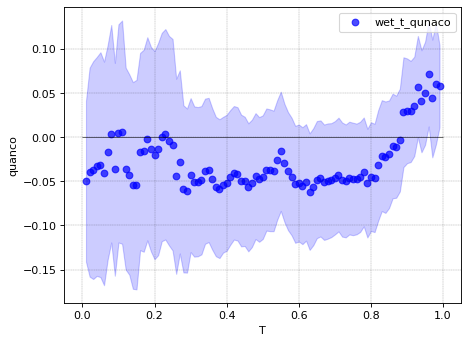

In [13]:
data = pd.DataFrame(data = np.arange(1,379,1),columns = ['x'])
data['y']= np.nanmean(tp_wet,axis=(1,2))
mod = smf.quantreg('y~x',data)

quantiles = np.arange(0.01,1,0.01)
models = []
params = []

for qt in quantiles:

    res = mod.fit(q = qt )
    models.append(res)
    params.append([qt, res.params['Intercept'], 
                   res.params['x']] + res.conf_int().loc['x'].tolist())


w_params = pd.DataFrame(data = params, 
                      columns = ['qt','intercept','x_coef','cf_lower_bound','cf_upper_bound'])



fig, ax = plt.subplots(dpi=80)
ax.scatter(quantiles, w_params['x_coef'], c="b", alpha=0.7, marker='o',label="wet_t_qunaco")
ax.fill_between(quantiles, w_params['cf_lower_bound'], w_params['cf_upper_bound'], alpha=0.2,color='b')
ax.set_xlabel("T")
ax.set_ylabel("quanco")
ax.legend()
ax.grid(linestyle='--',linewidth=0.3,alpha=0.5,color='k')
ax.hlines(y = 0,xmin=0,xmax=1,color='k',linestyles='-',lw=0.5)
#plt.savefig('wet_t_quanco.pdf')
plt.show()



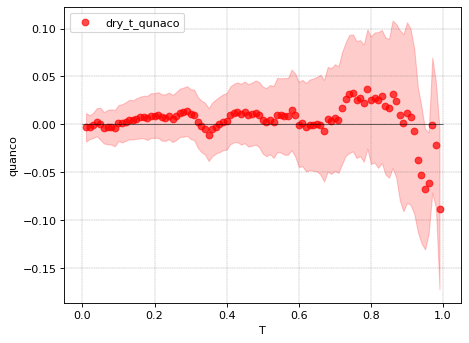

In [18]:
data = pd.DataFrame(data = np.arange(1,379,1),columns = ['x'])
data['y']= np.nanmean(tp_dry,axis=(1,2))
mod = smf.quantreg('y~x',data)


quantiles = np.arange(0.01,1,0.01)
models = []
params = []

for qt in quantiles:

    res = mod.fit(q = qt )
    models.append(res)
    params.append([qt, res.params['Intercept'], 
                   res.params['x']] + res.conf_int().loc['x'].tolist())


d_params = pd.DataFrame(data = params, 
                      columns = ['qt','intercept','x_coef','cf_lower_bound','cf_upper_bound'])


fig, ax = plt.subplots(dpi=80)
ax.scatter(quantiles, d_params['x_coef'],  c="r", alpha=0.7, marker='o',label="dry_t_qunaco")
ax.fill_between(quantiles, d_params['cf_lower_bound'], d_params['cf_upper_bound'], alpha=0.2,color='r')
ax.set_xlabel("T")
ax.set_ylabel("quanco")
ax.legend(loc=2)
ax.grid(linestyle='--',linewidth=0.3,alpha=0.5,color='k')
ax.hlines(y = 0,xmin=0,xmax=1,color='k',linestyles='-',lw=0.5)
#plt.savefig('dry_t_quanco.pdf')
plt.show()

Text(0.5, 1.0, 'different quantile regression')

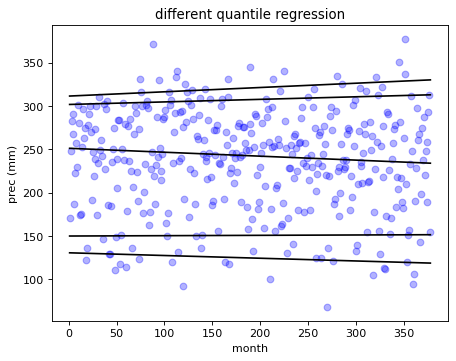

In [19]:
fig, ax = plt.subplots(dpi=80)
month = np.arange(1,379,1)
ax.scatter(month,np.nanmean(tp_wet,axis=(1,2)),c='b',alpha=0.3)
for i in (4,9,49,89,94):
    ax.plot(month, w_params['x_coef'][i]*month+w_params['intercept'][i], '-',color='k')

ax.set_xlabel("month")
ax.set_ylabel("prec (mm)")
ax.set_title("different quantile regression")
#plt.savefig('wet.pdf')

Text(0.5, 1.0, 'different quantile regression')

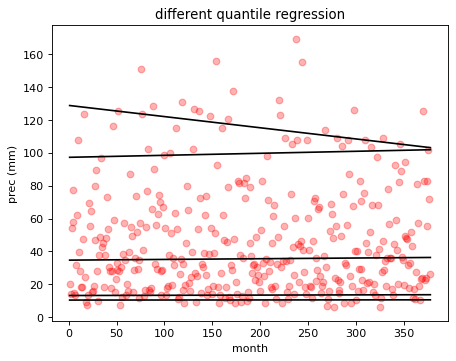

In [20]:
fig, ax = plt.subplots(dpi=80)
month = np.arange(1,379,1)
ax.scatter(month,np.nanmean(tp_dry,axis=(1,2)),c='r',alpha=0.3)
for i in (4,9,49,89,94):
    ax.plot(month, d_params['x_coef'][i]*month+d_params['intercept'][i], '-',color='k')

ax.set_xlabel("month")
ax.set_ylabel("prec (mm)")
ax.set_title("different quantile regression")
#plt.savefig('dry.pdf')

In [21]:
import seaborn as sn

In [22]:
dataw = pd.DataFrame(data = month, 
                      columns = ['month'])
dataw['prec'] = np.nanmean(tp_wet,axis=(1,2))

datad = pd.DataFrame(data = month, 
                      columns = ['month'])
datad['prec'] = np.nanmean(tp_dry,axis=(1,2))

<Axes: xlabel='Probability', ylabel='prec'>

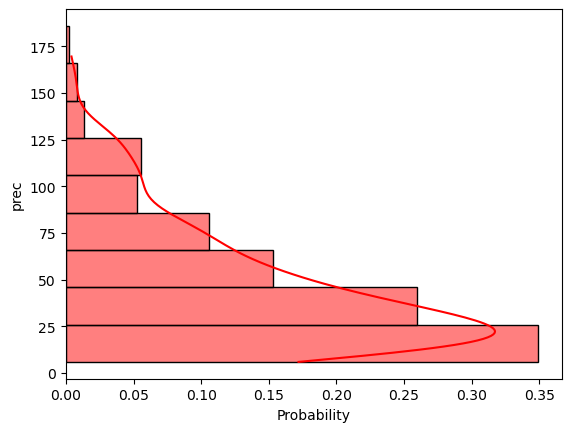

In [23]:
sns.histplot(data=datad, y="prec", kde=True,stat='probability',color='red',binwidth=20)


<Axes: xlabel='Probability', ylabel='prec'>

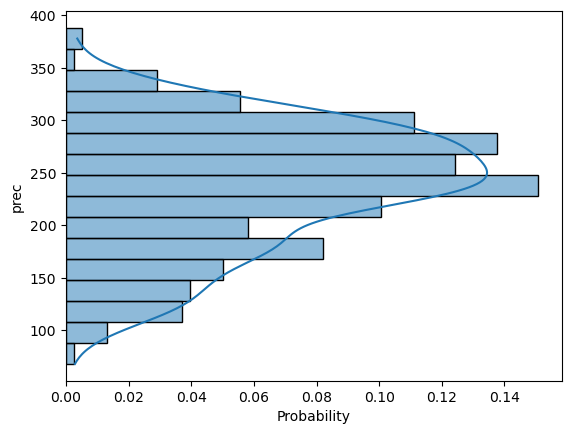

In [24]:
sns.histplot(data=dataw, y="prec", kde=True,stat='probability',binwidth=20)


# Trend coefficients with time as covariate derived from the classic quantile regression

In [25]:
tp_dry.shape

(378, 102, 61)

In [26]:

names = locals()
quantiles = (5,10,50,90,95)
for qt in quantiles:
    names['coef_time'+str(qt)]=[]
    for lat in range(0,102):
        for lon in range(0,61):

            data = pd.DataFrame(data = np.arange(1,379,1),columns = ['x'])
            if isnan(tp_wet[:,lat,lon][1]):
                names['coef_time'+str(qt)] = np.append(names['coef_time'+str(qt)],np.nan)
                
                
                
            else:
                data['y']= tp_wet[:,lat,lon]
                mod = smf.quantreg('y~x',data)

                quantiles = (0.05,0.5,0.95)
                models = []
                params = []



                res = mod.fit(q = qt/100 )
                models.append(res)
                params.append([qt, res.params['Intercept'], 
                                       res.params['x']] + res.conf_int().loc['x'].tolist())


                names['w_params'+str(qt)] = pd.DataFrame(data = params, 
                                       columns = ['qt','intercept','x_coef','cf_lower_bound','cf_upper_bound'])

                names['w_params'+str(qt)]['x_coef']
                names['coef_time'+str(qt)] = np.append(names['coef_time'+str(qt)],names['w_params'+str(qt)]['x_coef'])
    names['wcoef_time'+str(qt)] = names['coef_time'+str(qt)].reshape(102,61)


In [27]:

names = locals()
quantiles = (5,10,50,90,95)
for qt in quantiles:
    names['coef_time'+str(qt)]=[]
    for lat in range(0,102):
        for lon in range(0,61):

            data = pd.DataFrame(data = np.arange(1,379,1),columns = ['x'])
            if isnan(tp_dry[:,lat,lon][1]):
                names['coef_time'+str(qt)] = np.append(names['coef_time'+str(qt)],np.nan)
                
                
                
            else:
                data['y']= tp_dry[:,lat,lon]
                mod = smf.quantreg('y~x',data)

                quantiles = (0.05,0.5,0.95)
                models = []
                params = []



                res = mod.fit(q = qt/100 )
                models.append(res)
                params.append([qt, res.params['Intercept'], 
                                       res.params['x']] + res.conf_int().loc['x'].tolist())


                names['w_params'+str(qt)] = pd.DataFrame(data = params, 
                                       columns = ['qt','intercept','x_coef','cf_lower_bound','cf_upper_bound'])

                names['w_params'+str(qt)]['x_coef']
                names['coef_time'+str(qt)] = np.append(names['coef_time'+str(qt)],names['w_params'+str(qt)]['x_coef'])
    names['dcoef_time'+str(qt)] = names['coef_time'+str(qt)].reshape(102,61)

In [125]:
np.nanmax(wcoef_time95)

0.5477809122990767

Text(22, 15, 'quantile = 5%')

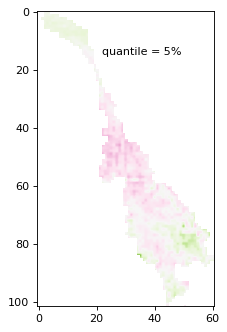

In [47]:
fig = plt.figure(dpi=80)
plt.imshow(wcoef_time5,cmap='PiYG',vmin=-0.4,vmax=0.4)
#plt.colorbar()
plt.text(22, 15, 'quantile = 5%')
#plt.savefig('wet50.pdf')

Text(22, 15, 'quantile = 5%')

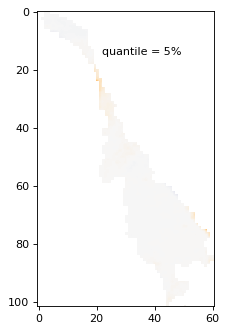

In [40]:
fig = plt.figure(dpi=80)
plt.imshow(dcoef_time5,cmap='PuOr',vmin=-0.4,vmax=0.4)
#plt.colorbar()
plt.text(22, 15, 'quantile = 5%')
#plt.savefig('wet50.pdf')